Monte Carlo Stock Price Simulator(NVDA)

Goal: Simulate possible 1 year future price paths for Nvidia using Monte Carlo simulation.

Steps:
1. Retrieves historical data of stock prices of Nvidia stock prices from Yahoo Finance.

2. Computes daily log returns and estimates drift and volatility.

3. Simulates many future paths using Geometric Brownian Motion(GBM) assumptions.

4. Reports key metrics like VaR (5%) and CVaR ( Expected Shortfall)

Key Modeling Assumptions:
- Log returns are independent and identically distributed.
- Returns follow a normal distribution with constant mu and sigma.
- No dividends, no transaction costs.





In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm

In [ ]:
ticker = "NVDA"
df = yf.download(ticker, start="2019-01-01", end="2026-01-01")

df = df.reset_index() #normal column
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Date", "Close"]].rename(columns={"Close": "price"}) #only keeps the required columns
df = df.dropna().sort_values("Date").reset_index(drop=True)#removes nulls and sorts data from oldest to newest
#print(df.head())


df["log_return"] = np.log(df["price"] / df["price"].shift(1)) #calculating log returns vals
df = df.dropna()
#print(df.head())

mu = df["log_return"].mean() #daily avg return
sigma = df["log_return"].std() # daily volatility
#print(f"mu: {round(mu, 5)}, sigma: {round(sigma, 5)}")


/tmp/ipython-input-3401431365.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2019-01-01", end="2026-01-01")
[*********************100%***********************]  1 of 1 completed


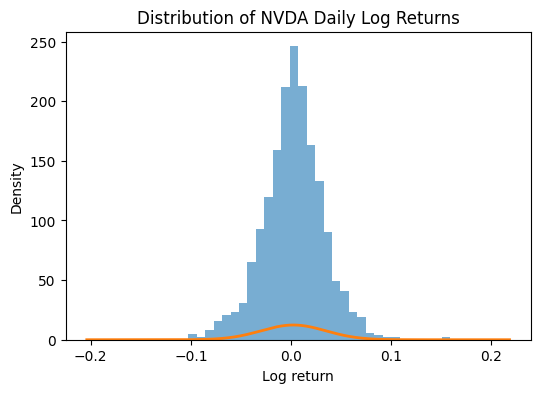

In [ ]:
# Inspecting Historical returns


plt.figure(figsize=(6, 4))
plt.hist(df["log_return"],bins = 50,alpha = 0.6)
x = np.linspace(df["log_return"].min(), df["log_return"].max(), 1500)
pdf = norm.pdf(x, mu, sigma)

plt.plot(x, pdf, label="Normal distribution", linewidth=2)
plt.title("Distribution of NVDA Daily Log Returns")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.show()

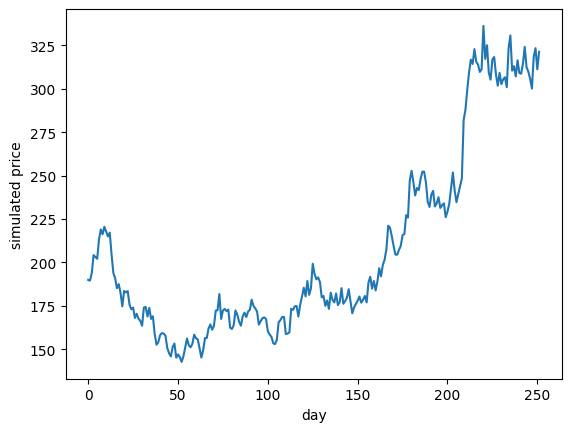

Min simulated price: 142.7123910200258
Max simulated price: 336.2254811837781
Final simulated price: 321.31859590324626


In [ ]:
# Single Simulated Path (Logic Check)

T = 252 # num trading days
num_paths = 1 # num simulation paths
s0 = df["price"].iloc[-1].item() # last day close price, extracted as a scalar

np.random.seed(42)

sim_log_returns = np.random.normal(loc=mu, scale=sigma, size=T)

growth_factors = np.exp(sim_log_returns)

price_path = s0 * np.cumprod(growth_factors)
#print(np.round(price_path, 2))
plt.plot(price_path)
plt.xlabel("day")
plt.ylabel("simulated price")
plt.show()

print("Min simulated price:", price_path.min())
print("Max simulated price:", price_path.max())
print("Final simulated price:", price_path[-1])


[ 407.09836835  177.21607871 1118.55161922 ...  444.69003126  188.5613877
  494.33432983]
375.58368072559006 329.7306857892095 140.64794398646728 762.0392516881245 0.131


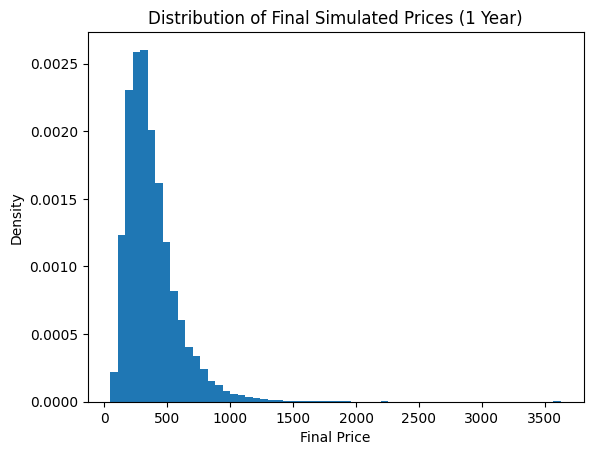

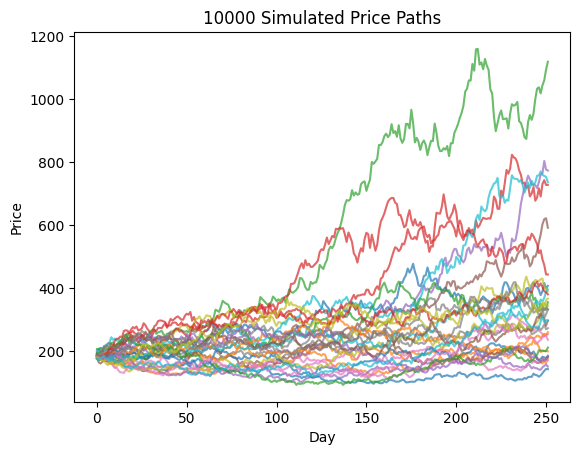

In [ ]:

#Monte Carlo Simulation (GBM, Normal Returns)



nums_sims = 10000 # number of simulations
sim_log_returns = np.random.normal(loc=mu, scale=sigma, size=(nums_sims, T)) #generates a matrix of random returns
#print(sim_log_returns.shape)

# Calculate growth factors for all simulations within this cell
growth_factors = np.exp(sim_log_returns)

# Calculate price paths for all simulations, compounding along the time dimension (axis=1)
price_path = s0 * np.cumprod(growth_factors, axis=1)
final_prices = price_path[:,-1] # simulated final prices
print(final_prices)


# Metrics
mean_price = final_prices.mean()
median_price = np.median(final_prices)
percentile_price_5 = np.percentile(final_prices, 5)
percentile_price_95 = np.percentile(final_prices, 95)
prob_loss = np.mean(final_prices < s0)


print(mean_price, median_price, percentile_price_5,percentile_price_95,prob_loss)


plt.hist(final_prices, bins=60, density=True)
plt.title("Distribution of Final Simulated Prices (1 Year)")
plt.xlabel("Final Price")
plt.ylabel("Density")
plt.show()


for i in range(30):
    plt.plot(price_path[i], alpha=0.7)
plt.title("10000 Simulated Price Paths")
plt.xlabel("Day")
plt.ylabel("Price")
plt.show()


In [ ]:
var_5 = np.percentile(final_prices, 5) # tells us 5% of outcomes are worse than this
cvar_5 = final_prices[final_prices <= var_5].mean() # tells us the average outcome in the worst 5% tail
print(var_5, cvar_5)


140.64794398646728 115.49531599129085


In [ ]:
# Use historical data for training and assess performance by comparing
# predictions to out-of-sample realized results.

train_df = df[df["Date"] <= "2024-12-31"].copy()
test_df = df[df["Date"] > "2024-12-31"].copy()

#train_df["Date"].max(),test_df["Date"].min()

mu_train = train_df["log_return"].mean()
sigma_train = train_df["log_return"].std()

#mu_train, sigma_train

T_test = len(test_df)
s0_test = train_df["price"].iloc[-1].item()

sim_log_returns_test = np.random.normal(loc=mu_train, scale=sigma_train, size=(nums_sims, T_test))
growth_test = np.exp(sim_log_returns_test)
price_paths_test = s0 * np.cumprod(growth_test, axis = 1)
final_prices_test = price_paths_test[:,1]


In [ ]:
act_final_price = test_df["price"].iloc[-1].item()
print(act_final_price)

actual_percentile = np.mean(final_prices_test < act_final_price)
actual_percentile



186.5


np.float64(0.4578)

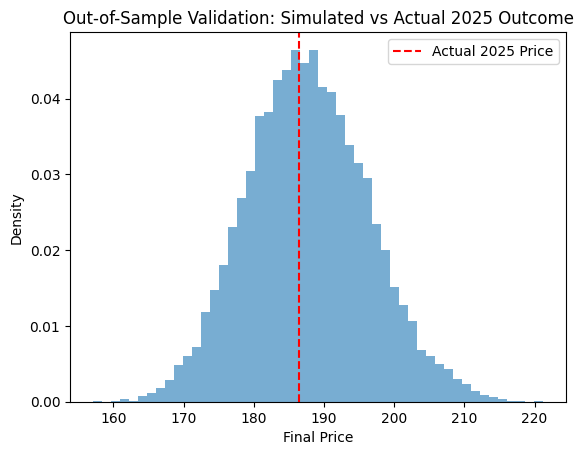

In [ ]:
plt.hist(final_prices_test,bins = 50, density = True, alpha = 0.6)
plt.axvline(act_final_price, color="red", linestyle="--", label="Actual 2025 Price")
plt.title("Out-of-Sample Validation: Simulated vs Actual 2025 Outcome")
plt.xlabel("Final Price")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
# Gaussian Mixture Model (Fat Tails)



from sklearn.mixture import GaussianMixture

returns = df["log_return"].values.reshape(-1, 1)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(returns)

gmm.means_, np.sqrt(gmm.covariances_), gmm.weights_


(array([[ 3.60931651e-03],
        [-2.88520035e-05]]),
 array([[[0.02116872]],
 
        [[0.04558054]]]),
 array([0.63475593, 0.36524407]))

In [ ]:
gmm_returns, _ = gmm.sample(nums_sims * T)
gmm_returns = gmm_returns.reshape(nums_sims, T)

growth_gmm = np.exp(gmm_returns)
price_paths_gmm = s0 * np.cumprod(growth_gmm, axis=1)
final_prices_gmm = price_paths_gmm[:, -1]

In [ ]:
np.percentile(final_prices, 5), np.percentile(final_prices_gmm, 5)


(np.float64(140.64794398646728), np.float64(84.011420366407))

In [ ]:
var5_norm = np.percentile(final_prices, 5)
cvar5_norm = final_prices[final_prices <= var5_norm].mean()

var5_gmm = np.percentile(final_prices_gmm, 5)
cvar5_gmm = final_prices_gmm[final_prices_gmm <= var5_gmm].mean()
print(var5_gmm,cvar5_gmm,var5_norm,cvar5_norm)

84.011420366407 61.93352265551725 140.64794398646728 115.49531599129085


Takeaways
- Monte Carlo provides a distribution of possible outcomes, not a single guess.
- VaR and CVaR translate the distribution into downside risk numbers.
- The GMM extension can change tail risk estimates because it relaxes the single normal assumption.


Next Steps:
- Compare more tickers or model a portfolio.